In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [4]:
folder_path = '/content/drive/MyDrive/EngrKalu/KaluAlibabaNotebooks/cluster-trace-gpu-v2023/csv'
dataframes = []

for filename in os.listdir(folder_path):
    # print(filename)
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
len(dataframes)

26

In [5]:
data = pd.concat(dataframes, ignore_index=True)
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,sn,gpu,model
0,openb-pod-0000,12000,16384,1.0,1000.0,NaN,LS,Running,0.0,12537496.0,0.0,NaN,NaN,NaN
1,openb-pod-0001,6000,12288,1.0,460.0,NaN,LS,Running,427061.0,12902960.0,427061.0,NaN,NaN,NaN
2,openb-pod-0002,12000,24576,1.0,1000.0,NaN,LS,Running,1558381.0,12902960.0,1558381.0,NaN,NaN,NaN
3,openb-pod-0003,6000,12288,1.0,460.0,NaN,LS,Running,2690044.0,12902960.0,2690044.0,NaN,NaN,NaN
4,openb-pod-0004,12000,16384,1.0,1000.0,NaN,LS,Running,2758084.0,12902960.0,2758084.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201928,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1208,2.0,T4
201929,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1209,2.0,T4
201930,NaN,104000,524288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1210,2.0,T4
201931,NaN,96000,393216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openb-node-1211,8.0,G2


In [6]:
data.isnull().sum()

,0
name,2736
cpu_milli,0
memory_mib,0
num_gpu,2736
gpu_milli,2736
gpu_spec,195241
qos,37375
pod_phase,37375
creation_time,37375
deletion_time,37375


In [7]:
data.dropna(subset =['scheduled_time'], inplace = True)
data.drop(['scheduled_time','sn','gpu','model','gpu_spec', 'creation_time', 'deletion_time'], axis =1, inplace = True)

In [8]:
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase
0,openb-pod-0000,12000,16384,1.0,1000.0,LS,Running
1,openb-pod-0001,6000,12288,1.0,460.0,LS,Running
2,openb-pod-0002,12000,24576,1.0,1000.0,LS,Running
3,openb-pod-0003,6000,12288,1.0,460.0,LS,Running
4,openb-pod-0004,12000,16384,1.0,1000.0,LS,Running
...,...,...,...,...,...,...,...
200715,openb-pod-8147,32200,132096,4.0,1000.0,LS,Failed
200716,openb-pod-8148,18708,64512,1.0,1000.0,LS,Running
200717,openb-pod-8149,11400,48128,1.0,1000.0,LS,Running
200718,openb-pod-8150,11400,48128,1.0,1000.0,LS,Running


In [9]:
# Preprocessing
# Encode categorical features
label_encoder = LabelEncoder()
data['name'] = label_encoder.fit_transform(data['name'])
data['qos'] = label_encoder.fit_transform(data['qos'])
data['pod_phase'] = label_encoder.fit_transform(data['pod_phase'])
data

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase
0,0,12000,16384,1.0,1000.0,3,1
1,1,6000,12288,1.0,460.0,3,1
2,2,12000,24576,1.0,1000.0,3,1
3,3,6000,12288,1.0,460.0,3,1
4,4,12000,16384,1.0,1000.0,3,1
...,...,...,...,...,...,...,...
200715,8218,32200,132096,4.0,1000.0,3,0
200716,8219,18708,64512,1.0,1000.0,3,1
200717,8220,11400,48128,1.0,1000.0,3,1
200718,8221,11400,48128,1.0,1000.0,3,1


In [10]:
data['qos'].unique()

array([3, 1, 0, 2])

In [11]:
# Normalize numerical features
scaler = StandardScaler()
numerical_cols = list(data.columns)[1:]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data = data.iloc[:, 1:]

In [12]:
data

,cpu_milli,memory_mib,num_gpu,gpu_milli,qos,pod_phase
0,0.203035,-0.574410,0.167927,0.872779,0.911643,0.509785
1,-0.496126,-0.697252,0.167927,-0.570930,0.911643,0.509785
2,0.203035,-0.328726,0.167927,0.872779,0.911643,0.509785
3,-0.496126,-0.697252,0.167927,-0.570930,0.911643,0.509785
4,0.203035,-0.574410,0.167927,0.872779,0.911643,0.509785
...,...,...,...,...,...,...
200715,2.556877,2.895867,4.771498,0.872779,0.911643,-1.566560
200716,0.984697,0.868980,0.167927,0.872779,0.911643,0.509785
200717,0.133119,0.377613,0.167927,0.872779,0.911643,0.509785
200718,0.133119,0.377613,0.167927,0.872779,0.911643,0.509785


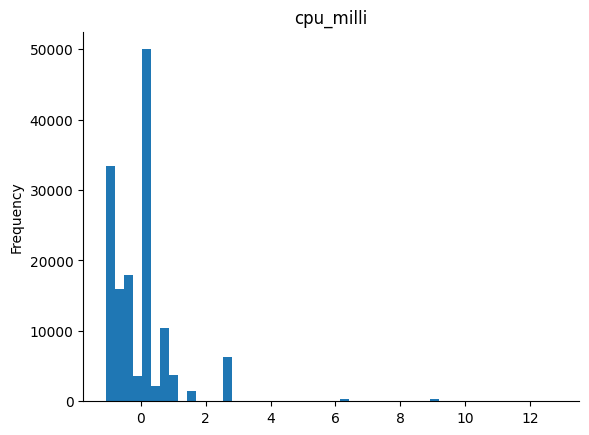

In [13]:
from matplotlib import pyplot as plt
data['cpu_milli'].plot(kind='hist', bins=50, title='cpu_milli')
plt.gca().spines[['top', 'right',]].set_visible(False)

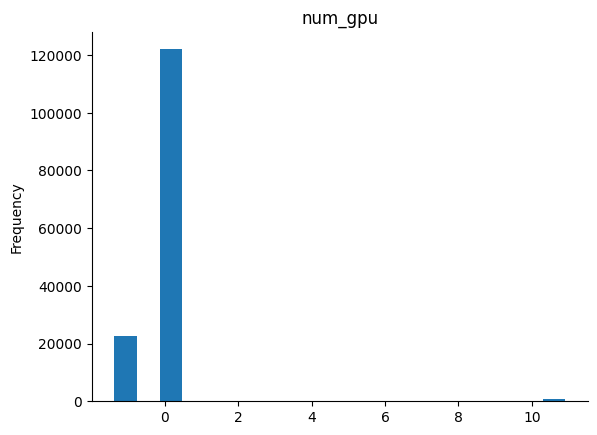

In [14]:
from matplotlib import pyplot as plt
data['num_gpu'].plot(kind='hist', bins=20, title='num_gpu')
plt.gca().spines[['top', 'right',]].set_visible(False)

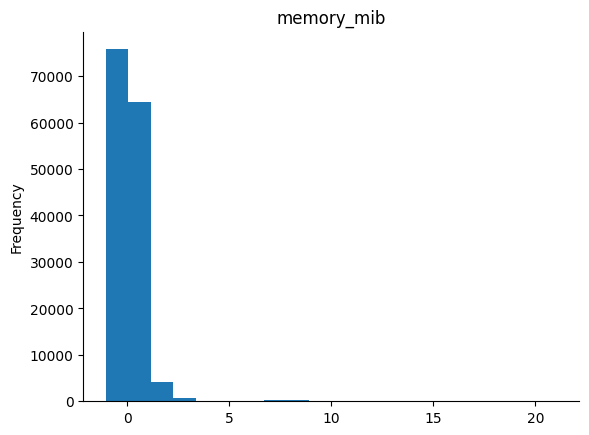

In [15]:
from matplotlib import pyplot as plt
data['memory_mib'].plot(kind='hist', bins=20, title='memory_mib')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
# from matplotlib import pyplot as plt
# data['name'].plot(kind='hist', bins=20, title='name')
# plt.gca().spines[['top', 'right',]].set_visible(False)

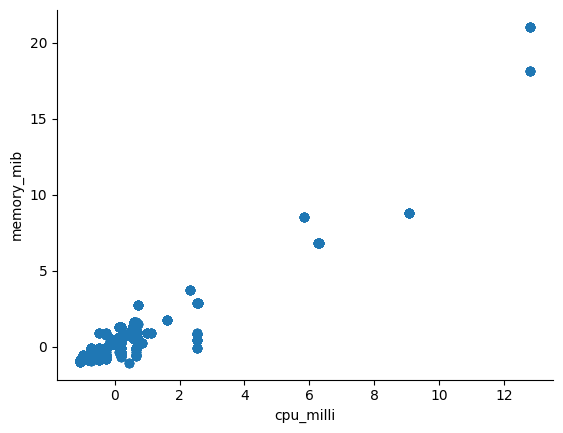

In [17]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='cpu_milli', y='memory_mib', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

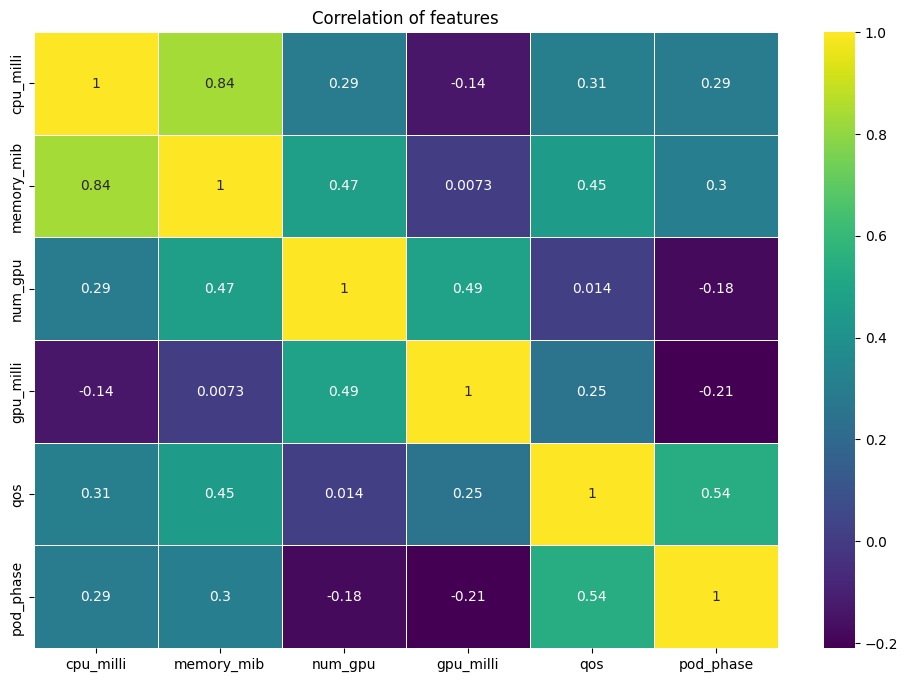

In [18]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(),annot=True, cmap='viridis', linewidths=0.5)
plt.title("Correlation of features");

In [58]:
# Split the data
X = data.drop(columns=['gpu_milli'])
y = data['gpu_milli']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer with a dropout rate of 0.5
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Train the model
history_ann = model_ann.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

# Evaluate the model
loss = model_ann.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

# Make predictions
predictions = model_ann.predict(X_test)


Epoch 1/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5031 - val_loss: 0.1862
Epoch 2/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2318 - val_loss: 0.1773
Epoch 3/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2051 - val_loss: 0.1712
Epoch 4/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1892 - val_loss: 0.1625
Epoch 5/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1769 - val_loss: 0.1568
Epoch 6/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1675 - val_loss: 0.1534
Epoch 7/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1574 - val_loss: 0.1477
Epoch 8/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1506 - val_loss: 0.1470
Epoch 9/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1435 - val_loss: 0.1424
Epoch 10/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1373 - val_loss: 0.1333
Epoch 11/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1282 - val_loss: 0.1189
Epoch 12/50
1595/1595 ━━━━━━━

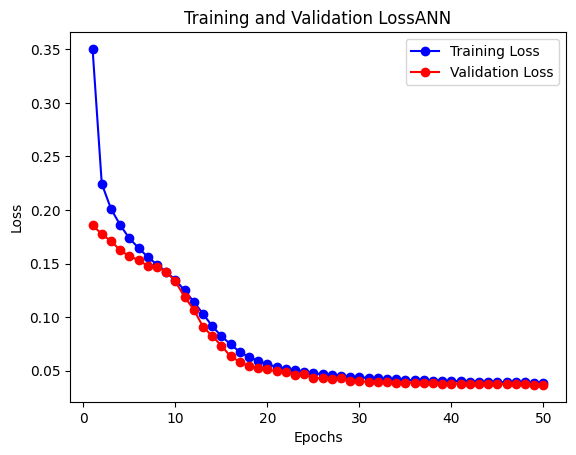

In [22]:
# FUntion to plot the model training history
def history(history, name):
  # Access the training history to get loss values
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  # Create a range of epochs for the x-axis
  epochs = range(1, len(training_loss) + 1)

  # Plot training and validation loss
  plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
  plt.plot(epochs, validation_loss, label='Validation Loss', color='red', marker='o')

  plt.title(f'Training and Validation Loss{name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


# Scatter plot to visualize actual vs the predicted values

def dataplot(y_test, y_pred, name):
  plt.scatter(y_test, y_pred)
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  plt.title(f"{name} True_Values vs. Predictions")

  # Add the line of best fit (y = x)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label="Line of Best Fit")

  plt.show()


history(history_ann, "ANN")


In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_ann = model_ann.predict(X_test)
mse = mean_squared_error(y_test, y_pred_ann)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_ann)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_ann)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error (MSE): 0.03719904105821881
Root Mean Squared Error (RMSE): 0.19287052926307535
Mean Absolute Error (MAE): 0.1178995519508815
R-squared (R²) Score: 0.96276482997051


In [24]:
# Reshape the input data for the RNN model
import numpy as np

# Convert the DataFrame to a NumPy array
X_train_array = X_train.to_numpy()
X_val_array = X_val.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape the input data for the RNN model
X_train_rnn = np.reshape(X_train_array, (X_train_array.shape[0], X_train_array.shape[1], 1))
X_val_rnn = np.reshape(X_val_array, (X_val_array.shape[0], X_val_array.shape[1], 1))
X_test_rnn = np.reshape(X_test_array, (X_test_array.shape[0], X_test_array.shape[1], 1))




model_rnn = tf.keras.Sequential([
    LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)  # Output layer for regression
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history_rnn = model_rnn.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val), epochs=50, batch_size=256, callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.7554 - val_loss: 0.1430
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1087 - val_loss: 0.0605
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0577 - val_loss: 0.0531
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0511 - val_loss: 0.0474
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0469 - val_loss: 0.0482
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0462 - val_loss: 0.0438
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0453 - val_loss: 0.0442
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0444 - val_loss: 0.0417
Epoch 9/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0425 - val_loss: 0.0400
Epoch 10/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0413 - val_loss: 0.0437
Epoch 11/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0400 - val_loss: 0.0387
Epoch 12/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

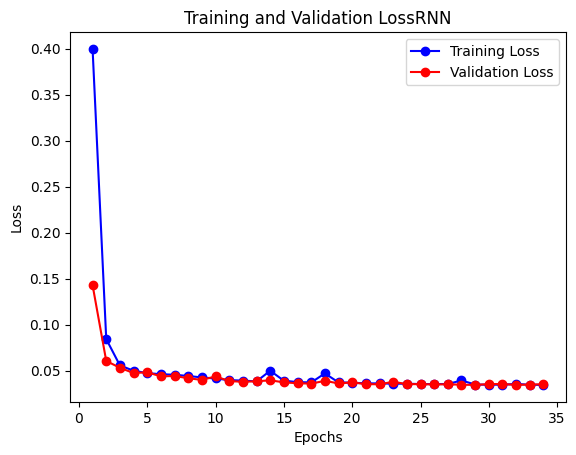

In [25]:
history(history_rnn, "RNN")

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_rnn = model_rnn.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rnn)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_rnn)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_rnn)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Mean Squared Error (MSE): 0.033919533721812445
Root Mean Squared Error (RMSE): 0.1841725650628031
Mean Absolute Error (MAE): 0.10015091423577926
R-squared (R²) Score: 0.9660475224757532


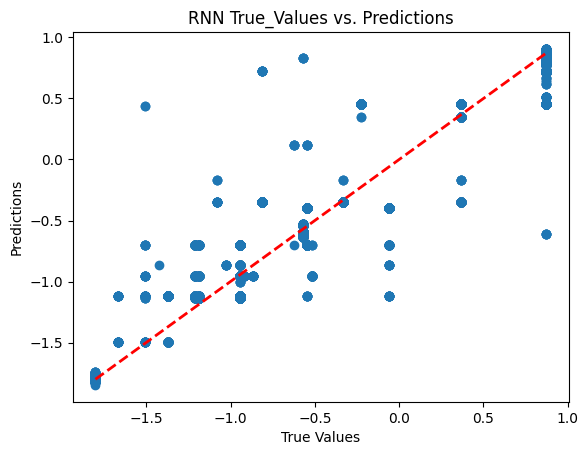

In [27]:
dataplot(y_test, y_pred_rnn, "RNN")

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Assuming you have your data loaded into a DataFrame named 'data'
# Separate the features and target variable
X = data.drop(columns=['gpu_milli'])
y = data['gpu_milli']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape the input data for the CNN model
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create a CNN model
model_cnn = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=30, batch_size=64, validation_data=(X_test_cnn, y_test))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2786 - val_loss: 0.1034
Epoch 2/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0845 - val_loss: 0.0567
Epoch 3/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0550 - val_loss: 0.0464
Epoch 4/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0472 - val_loss: 0.0421
Epoch 5/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0439 - val_loss: 0.0407
Epoch 6/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0413 - val_loss: 0.0405
Epoch 7/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0416 - val_loss: 0.0383
Epoch 8/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0403 - val_loss: 0.0496
Epoch 9/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0435 - val_loss: 0.0391
Epoch 10/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0402 - val_loss: 0.0393
Epoch 11/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0396 - val_loss: 0.0377
Epoch 12/30
1595/1595 ━━━━━━━━━━━━━━━━━━━

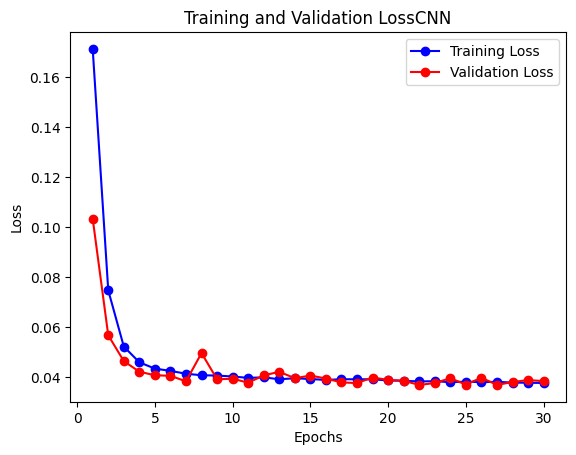

In [49]:
history(history_cnn, "CNN")

In [68]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_cnn = model_cnn.predict(X_test)
mse = mean_squared_error(y_test, y_pred_cnn)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_cnn)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_cnn)
print("R-squared (R²) Score:", r2)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (MSE): 0.03845261197812601
Root Mean Squared Error (RMSE): 0.19609337566099985
Mean Absolute Error (MAE): 0.12442681395620178
R-squared (R²) Score: 0.9615100415399772


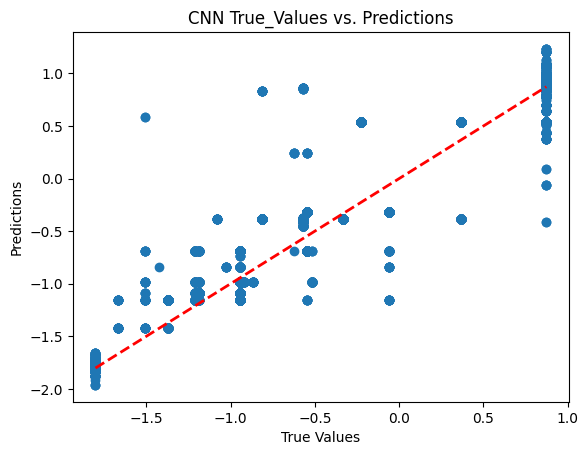

In [69]:
dataplot(y_test, y_pred_cnn, "CNN")

# Ploting the model performance

In [32]:
# Create a dictionary to store the model outputs
dict_1 = {
    'Model': ['ANN', 'RNN', 'CNN'],
    'MSE': [0.09768265459338259, 0.036368198027815574, 0.03651171933983445],
    'RMSE': [0.3125422444940565, 0.19070447825841838, 0.1910804001980173],
    'MAE': [0.14769309605157563, 0.07110994900965997, 0.0807924558347365],
    'R-squared (R²) Score': [0.9094577589076617, 0.966290247049127, 0.9654258806984894]
}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict_1)

# Print the DataFrame
df


,Model,MSE,RMSE,MAE,R-squared (R²) Score
0,ANN,0.097683,0.312542,0.147693,0.909458
1,RNN,0.036368,0.190704,0.071110,0.966290
2,CNN,0.036512,0.191080,0.080792,0.965426


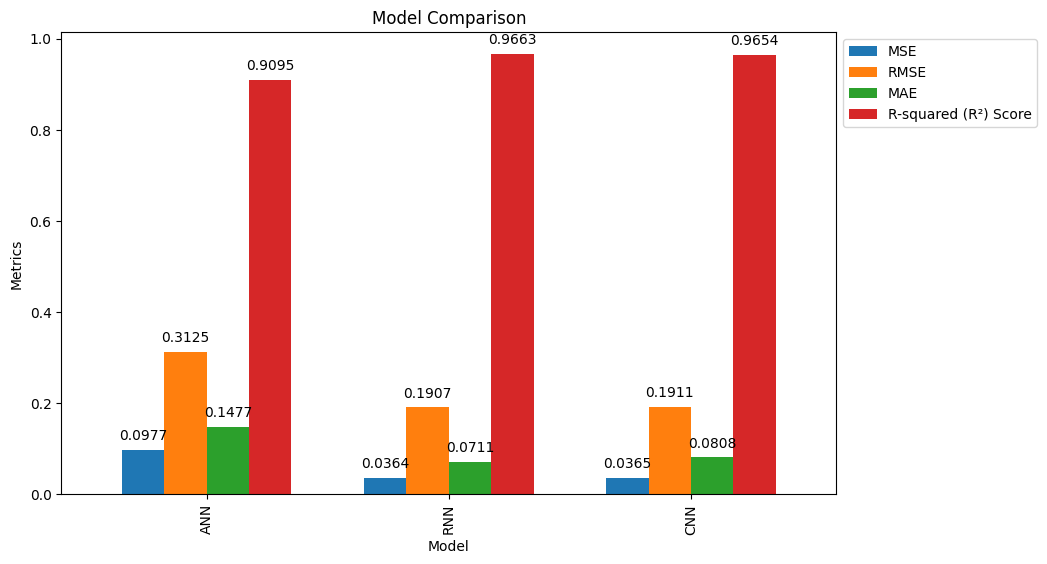

In [33]:
# Create a bar plot with increased bar size and values on top
ax = df.plot(x='Model', y=['MSE', 'RMSE', 'MAE', 'R-squared (R²) Score'], kind='bar', width=0.7, figsize=(10, 6))

plt.title('Model Comparison')
plt.ylabel('Metrics')

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Place the legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [73]:
# Flatten the predictions if they are 2D arrays
predictions_flat = [item[0] for item in predictions]
y_pred_cnn_flat = [item[0] for item in y_pred_cnn]
y_pred_rnn_flat = [item[0] for item in y_pred_rnn]

# Create the DataFrame
result = pd.DataFrame({
    'y_test': y_test,
    'predictions': predictions_flat,
    'y_pred_cnn': y_pred_cnn_flat,
    'y_pred_rnn': y_pred_rnn_flat
})

In [75]:
result.to_csv('GPU_millTrace_Prediction_result.csv', index=False)

In [76]:
# For ANN model
model_ann.save('model_ann.h5')

# For CNN model
model_cnn.save('model_cnn.h5')

# For RNN model
model_rnn.save('model_rnn.h5')
